# **Predicting Building Permit Issuance Times for San Francisco?**
##                                                                                             ...and answering many questions!


**A Data Science Project**     
*by Aparna Shastry*

## Content
+ Introduction
+ Data
+ What Are We Trying to Find Out?
+ Cleaning the Data
+ Exploratory Data Analysis

## Introduction
A building permit is an official approval document issued by a governmental agency that allows you or your contractor to proceed with a construction or remodeling project on one's property. For more details click [here](https://www.thespruce.com/what-is-a-building-permit-1398344). Each city or county has its own office related to buildings, that can do multiple functions like issuing permits, inspecting buildings to enforce safety measures, modifying rules to accommodate needs of the growing population etc. For the city of San Francisco, permit issuing is taken care by [Permit Services wing of Department of Building Inspection](http://sfdbi.org/permit-services) (henceforth called DBI).
The delays in permit issuance pose serious problems to construction industries and later on real estate agencies.Read this [Trulia study](https://www.trulia.com/blog/trends/elasticity-2016/) and [Vancouver city article](https://biv.com/article/2014/11/city-building-permit-delays-costing-developers-tim).

## Data
Data for this project is available in San Francisco city open data portal. It is updated every Saturday.
1. Go to the link: [SF](https://data.sfgov.org/Housing-and-Buildings/Building-Permits/i98e-djp9/data) open portal. 
2. Click on Filter and "Add a Filter Condition".
3. A drop down menu appears.
4. Select, "Filed Date" and "is after".
5. I entered date as 12/31/2012, because I wanted to do analysis of last 4-5 years. I think most recent data is important in matters such as this, the city council policies could change, there might be new rules, new employers to expedite process etc. Old data may not be too useful in modeling.
6. I chose to download in CSV format because it is of the less than 100MB size and easy to load into notebook. If it gave issues, I might have chosen a different format.

The file as of Feb 25, 2018 (Sunday) has been downloaded and kept for easy access. Size is about 75MB

### What Are We Trying to Find Out?

Primary Objective of this project is to model the building permit issuance times using at least last 3 years of permit filing/issuing data, so that this model can be used to predict the permit issuance times for the applications filed in future. Apart from that, this work will address a few concerns/answers a few questions which are of help in practical life in construction industry. We will get to the specifics once we get initial glimpse of columns in the data.

### Scope of this Document
This document explains the numerical and visual Exploratory Data Analysis done on the cleaned data

In [1]:
import os
import pandas as pd
import numpy as np
import time
import datetime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='white')

from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import folium

C:\Users\Aparn\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\Aparn\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%%time
# Read and make a copy for speed
sf = pd.read_csv('../data/Building_Permits.csv',low_memory=False)
sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 43 columns):
Permit Number                             198900 non-null object
Permit Type                               198900 non-null int64
Permit Type Definition                    198900 non-null object
Permit Creation Date                      198900 non-null object
Block                                     198900 non-null object
Lot                                       198900 non-null object
Street Number                             198900 non-null int64
Street Number Suffix                      2216 non-null object
Street Name                               198900 non-null object
Street Suffix                             196132 non-null object
Unit                                      29479 non-null float64
Unit Suffix                               1961 non-null object
Description                               198610 non-null object
Current Status                            198900 n

### What are We Trying to Find Out (Continued):

Specifically, we will be trying to answer the following in the next parts:

+ **Data Cleaning:**      
1) Which of these columns we should retain for further analysis? This is the first question to answer because eliminating obviously non-useful columns would save lot of time.        
2) How to interpret the records with zero or very small values for cost variables related to the construction?                
3) What to do we do if dates map to Saturday or Sunday? A date having invalid numbers for month and day of the month?      
4) Should we replace blanks in some columns where the valid value is 'Y'?    
5) What do we do with blank cells in date columns?    
         
+ **Exploratory Data Analysis:**   
1) What is the best day of the week to visit DBI, to file an application form? Is the popular belief “mid-week (Wednesday) is the least crowded and hence best to visit government or city agencies” true in this case?    
2) Which weekday has maximum percentage of permits issued on the same day, among the 5 weekdays?        
3) What type of permits are mostly issued on the same day of filing?     
4) Which types take least average time issue if not issued on the same day?    
5) Is there any particular quarter of each year which has higher application counts or average wait times? Can it be justified from the business knowledge?    
6) How does the wait time  vary across plansets?  
7) How is permit times related to cost?


In [3]:
# Conversion to datetime
import traceback
try :
    sf['Filed Date'] = pd.to_datetime(sf['Filed Date'],errors='coerce')
    sf['Issued Date'] = pd.to_datetime(sf['Issued Date'],errors='coerce')
    sf['Permit Expiration Date'] = pd.to_datetime(sf['Permit Expiration Date'],errors='coerce')
except :    
    traceback.print_exc()

# Keep a copy to reload
sfcpy = sf.copy()

In [4]:
# Sometimes when re-run is required, one can start from just here, to save time
sf = sfcpy.copy()

In [5]:
# Rename for brevity/readability
sf = sf.rename(columns =   {'Neighborhoods - Analysis Boundaries':'neighborhoods',
                            'Permit Type' : 'perm_typ',
                            'Permit Type Definition': 'perm_typ_def',
                            'Filed Date':'file_dt',
                            'Issued Date':'issue_dt',
                            'Permit Expiration Date' : 'perm_exp_dt',
                            'Structural Notification':'strct_notif',
                            'Number of Existing Stories':'no_exist_stry',
                            'Number of Proposed Stories':'no_prop_stry',
                            'Fire Only Permit':'fire_only_permit',
                            'Estimated Cost':'est_cost',
                            'Revised Cost':'rev_cost',
                            'Existing Use':'exist_use',
                            'Proposed Use': 'prop_use',
                            'Plansets':'plansets',
                            'Existing Construction Type': 'exist_const_type',
                            'Existing Construction Type Description': 'exist_const_type_descr',
                            'Proposed Construction Type': 'prop_const_type',
                            'Proposed Construction Type Description': 'prop_const_type_descr',
                            'Site Permit':'site_permit',
                            'Supervisor District':'sup_dist',
                            'Location':'location'
                            })

In [6]:
sf.columns

Index(['Permit Number', 'perm_typ', 'perm_typ_def', 'Permit Creation Date',
       'Block', 'Lot', 'Street Number', 'Street Number Suffix', 'Street Name',
       'Street Suffix', 'Unit', 'Unit Suffix', 'Description', 'Current Status',
       'Current Status Date', 'file_dt', 'issue_dt', 'Completed Date',
       'First Construction Document Date', 'strct_notif', 'no_exist_stry',
       'no_prop_stry', 'Voluntary Soft-Story Retrofit', 'fire_only_permit',
       'perm_exp_dt', 'est_cost', 'rev_cost', 'exist_use', 'Existing Units',
       'prop_use', 'Proposed Units', 'plansets', 'TIDF Compliance',
       'exist_const_type', 'exist_const_type_descr', 'prop_const_type',
       'prop_const_type_descr', 'site_permit', 'sup_dist', 'neighborhoods',
       'Zipcode', 'location', 'Record ID'],
      dtype='object')

## Cleaning the Data

The Tricky part of Data Wrangling in my knowledge so far,   

a) Knowing what is present in the 'null' cells, is it NaN or simply ' '     
b) In the non-null cells, if the all values are meaningful       
c) Recognizing that even if a column has all non-null and meaningful values, the future updates to the column may have problems. Hence need to expect it and handle it      
d) See the data and think if certain value make sense for the business and decide to drop those which are not relevant

##### Answering the questions:
1) The following columns are retained for further analysis. More could be added after discussion

In [7]:
sfr = sf[['perm_typ','perm_typ_def','file_dt','issue_dt','perm_exp_dt','strct_notif','no_exist_stry','no_prop_stry','fire_only_permit','est_cost','rev_cost',
          'exist_use','prop_use','plansets','exist_const_type','prop_const_type','site_permit','neighborhoods',
          'sup_dist','location']].copy()
sfr = sfr.sort_values('file_dt')

2) NaN or too small costs: Cost of the project is an essential part of the application according to [this post](http://www.herald-journal.com/housing/pages/older/permit.html). Examining if the cost columns have valid values.

In [8]:
print('Percentage of null values in revised cost:',round(100*sfr['rev_cost'].isnull().sum()/sfr['rev_cost'].isnull().count(),4))
print('Percentage of null values in estimated cost:',round(100*sfr['est_cost'].isnull().sum()/sfr['est_cost'].isnull().count(),4))

Percentage of null values in revised cost: 3.0498
Percentage of null values in estimated cost: 19.1383


In [9]:
print('Percentage of values < 10$ in estimated cost: {:.2f} and the same in revised cost is {:.2f}'
     .format(100*(sfr['est_cost'] < 10).sum()/(sfr['est_cost'] < 10).count(),100*(sfr['rev_cost'] < 10).sum()/(sfr['rev_cost'] < 10).count() ))

Percentage of values < 10$ in estimated cost: 8.56 and the same in revised cost is 28.03


Revised cost is most recent, and also has less null values compared to estimated cost. Hence, revised cost is more meaningful. However, since estimated cost has 20% null values, examining the time taken for those records might reveal something. Permit application without cost estimation might be delayed. The moment revised cost was entered, application might be processed. We would know that in the EDA part. For now, it is best to leave these alone. We could come back after cleaning some more columns

3) Dealing with dates falling on weekends: I would attribute it to typing mistake and make it previous or next day respectively. This may not be accurate, however it will not show a weekend in the EDA part.   

In [10]:
sfr[['file_dt','issue_dt','perm_typ']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198900 entries, 559 to 198761
Data columns (total 3 columns):
file_dt     198900 non-null datetime64[ns]
issue_dt    183960 non-null datetime64[ns]
perm_typ    198900 non-null int64
dtypes: datetime64[ns](2), int64(1)
memory usage: 6.1 MB


Note that permit type and file dates have no NaNs, whereas issue date has 14940 NaNs, because at the time of data download, they were not yet issued. We decide to keep it as is at this stage, because dropping them would introduce survivorship bias in others. Imputation would still introduce bias.

In [11]:
sfr = sfr.assign(time_taken = (sfr['issue_dt'] - sfr['file_dt']).dt.days)

In [12]:
sfr = sfr.assign(file_day = sfr.file_dt.dt.weekday_name)
sfr = sfr.assign(issue_day = sfr.issue_dt.dt.weekday_name)
sfr.loc[sfr['file_day']=='Saturday','file_dt']  = sfr.loc[sfr['file_day']=='Saturday','file_dt'] - datetime.timedelta(1)
sfr.loc[sfr['file_day']=='Saturday','file_day'] = 'Friday'
sfr.loc[sfr['file_day']=='Sunday','file_dt'] =  sfr.loc[sfr['file_day']=='Sunday','file_dt'] + datetime.timedelta(1)
sfr.loc[sfr['file_day']=='Sunday','file_day'] = 'Monday'
sfr.loc[sfr['issue_day']=='Saturday','issue_dt'] = sfr.loc[sfr['issue_day']=='Saturday','issue_dt'] - datetime.timedelta(1)
sfr.loc[sfr['issue_day']=='Saturday','issue_day'] = 'Friday'
sfr.loc[sfr['issue_day']=='Sunday','issue_dt'] = sfr.loc[sfr['issue_day']=='Sunday','issue_dt'] + datetime.timedelta(1)
sfr.loc[sfr['issue_day']=='Sunday','issue_day'] = 'Monday'

4) In the application forms (both physical or online), normally the applicant is supposed to tick the option if applicable. Otherwise nothing needs to be done. Hence it is understandable that blanks mean not applicable, a "No".

In [13]:
# Fill na with N. because in building permit databases, this is ticked if yes and left blank if it is not applicable
sfr['fire_only_permit'].fillna('N',inplace=True)
sfr['site_permit'].fillna('N',inplace=True)
sfr['strct_notif'].fillna('N',inplace=True)

One needs to constantly remind oneself that this is a building permit application. Absence of values in some columns can not be filled in isolation. For example, revised cost null values might mean applicant does not want to reveal the cost. Same with 0 cost. We will plot a bar chart. Even though this is data wrangling part and not EDA, sometimes the boundary is very thin

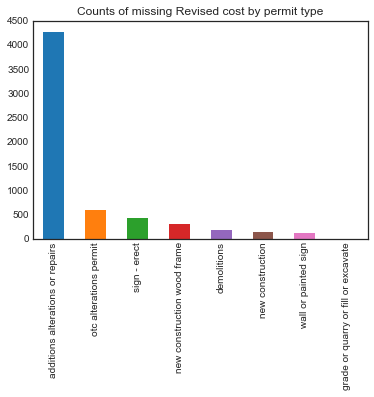

In [14]:
_ = sfr.loc[sfr.rev_cost.isnull(),'perm_typ_def'].value_counts().plot.bar()
_ = plt.title('Counts of missing Revised cost by permit type')

In [15]:
sfr.groupby('perm_typ')['rev_cost'].describe()

,count,mean,std,min,25%,50%,75%,max
perm_typ,,,,,,,,
1,206.0,5.374473e+07,9.015414e+07,8000.0,6776200.0,22900000.0,51875000.0,780500000.0
2,640.0,2.154835e+06,6.840046e+06,15000.0,498485.0,706841.0,1111231.5,123000000.0
3,10387.0,5.436800e+05,4.121239e+06,0.0,25000.0,100000.0,339235.0,266061486.0
4,2463.0,4.880860e+03,8.369167e+03,1.0,1500.0,3000.0,5000.0,150000.0
5,88.0,1.229301e+06,2.369108e+06,1.0,42625.0,400000.0,1456750.0,14800000.0
6,422.0,1.148496e+05,4.188830e+05,1.0,10000.0,25000.0,97250.0,6300000.0
7,385.0,1.825654e+03,4.282570e+03,1.0,400.0,800.0,2000.0,50000.0
8,178243.0,4.124766e+04,1.986577e+05,0.0,1.0,6000.0,24000.0,25000000.0


Looking at the matrix above, it seems unlikely that nulls or very small values of rev_cost is really so small. We should impute the missing or too small values, instead of dropping those rows. There are several options, like replacing by mean or median. Here we see that across permit types, revised cost has too much variability. Hence it may be worthwhile to consider replacing the median of each permit type. This is still too soon, we will postpone this for EDA.

In [16]:
sfr['rev_cost'].fillna(sfr['rev_cost'].min(),inplace=True)

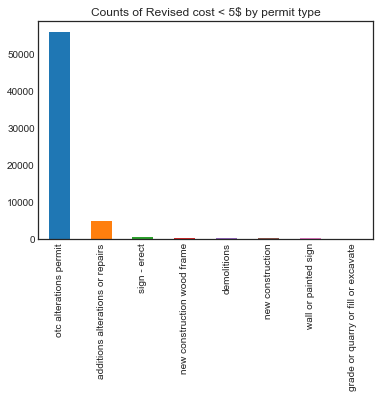

In [17]:
_ = sfr.loc[sfr.rev_cost < 5,'perm_typ_def'].value_counts().plot.bar()
_ = plt.title('Counts of Revised cost < 5$ by permit type')

Interesting to see that the first two positions are exchanged in the last two plots!

In [18]:
sfr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198900 entries, 559 to 198761
Data columns (total 23 columns):
perm_typ            198900 non-null int64
perm_typ_def        198900 non-null object
file_dt             198900 non-null datetime64[ns]
issue_dt            183960 non-null datetime64[ns]
perm_exp_dt         147020 non-null datetime64[ns]
strct_notif         198900 non-null object
no_exist_stry       156116 non-null float64
no_prop_stry        156032 non-null float64
fire_only_permit    198900 non-null object
est_cost            160834 non-null float64
rev_cost            198900 non-null float64
exist_use           157786 non-null object
prop_use            156461 non-null object
plansets            161591 non-null float64
exist_const_type    155534 non-null float64
prop_const_type     155738 non-null float64
site_permit         198900 non-null object
neighborhoods       197175 non-null object
sup_dist            197183 non-null float64
location            197200 non-null obj

In [19]:
sfr = sfr.assign(month = sfr['file_dt'].dt.month)
sfr = sfr.assign(year = sfr['file_dt'].dt.year)

There is no need to check for validity in month or days because otherwise datatime conversion would have failed.

In [20]:
print('There is {}% NaN in plansets'.format(round(100*sfr[sfr.exist_const_type.isnull()]['plansets'].isnull().sum()/sfr.shape[0],2)))

There is 18.76% NaN in plansets


We let the NaN's in exist_const_type,prop_const_type,no_exist_stry,no_prop_stry, and plansets as they are because this is building permit application. If it is not mentioned, it is not applicable.

In [21]:
# Fill location unknowns with 0's to indicate, it is unknown
sfr.location.fillna('(0,0)',inplace=True)
sfr.location = sfr.location.apply(lambda x: tuple([float((str(x).split('(')[1]).split(',')[0]),float((str(x).split('(')[1]).split(',')[1].split(')')[0])]))

In [22]:
# Replace nans with strings "Unknown"
sfr.exist_use.fillna('Unknown',inplace=True)
sfr.prop_use.fillna('Unknown',inplace=True)

# Some more variables
sfr.neighborhoods.fillna('Unknown',inplace=True)
sfr.sup_dist.fillna('Unknown',inplace=True)

# Taking care to ensure that future data will not have Nans
# Currently none

In [23]:
sfr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198900 entries, 559 to 198761
Data columns (total 25 columns):
perm_typ            198900 non-null int64
perm_typ_def        198900 non-null object
file_dt             198900 non-null datetime64[ns]
issue_dt            183960 non-null datetime64[ns]
perm_exp_dt         147020 non-null datetime64[ns]
strct_notif         198900 non-null object
no_exist_stry       156116 non-null float64
no_prop_stry        156032 non-null float64
fire_only_permit    198900 non-null object
est_cost            160834 non-null float64
rev_cost            198900 non-null float64
exist_use           198900 non-null object
prop_use            198900 non-null object
plansets            161591 non-null float64
exist_const_type    155534 non-null float64
prop_const_type     155738 non-null float64
site_permit         198900 non-null object
neighborhoods       198900 non-null object
sup_dist            198900 non-null object
location            198900 non-null obje

In [24]:
# Save the clean file
sfr.to_csv('../data/building_permit_clean.csv',index=True)

### Exploratory Data Analysis/Data Story Telling

#### Time Taken Variable

In [25]:
np.round(sfr.time_taken.describe(),2)

count    183960.00
mean         26.05
std          91.06
min           0.00
25%           0.00
50%           0.00
75%           6.00
max        1740.00
Name: time_taken, dtype: float64

+ The average wait time is 26 days
+ Standard deviation is too high at 91, and that is due to a very few large wait outliers

This variable needs a bit of scrutiny before its relation to other variables be understood. We will see how it varies across the months and years.

In [26]:
count_appl_month = sfr.groupby(['year','month'])['time_taken'].count()
avg_days_month = sfr.groupby(['year','month'])['time_taken'].mean()

print('Average wait time by year:')
print(np.round(sfr.groupby('year')['time_taken'].mean(),2))

print('Total permits processed by year:')
print(np.round(sfr.groupby('year')['time_taken'].count(),2))

Average wait time by year:
year
2013    26.44
2014    31.84
2015    33.61
2016    28.66
2017    12.42
2018     2.15
Name: time_taken, dtype: float64
Total permits processed by year:
year
2013    33859
2014    34925
2015    37991
2016    36751
2017    35919
2018     4515
Name: time_taken, dtype: int64


Text(0.5,1,'Normalized Permit Count')

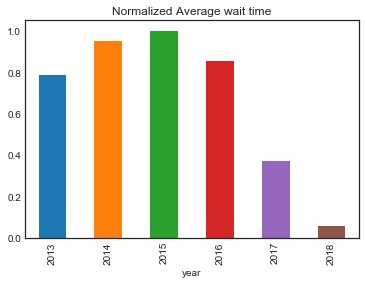

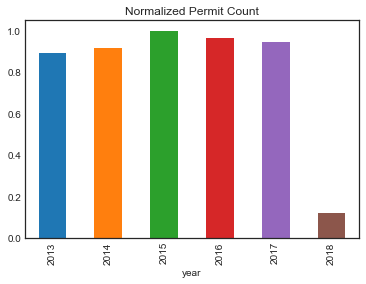

In [27]:
# Bar Plots of the same
(avg_days_month.groupby('year').mean()/avg_days_month.groupby('year').mean().max()).plot.bar()
plt.title('Normalized Average wait time')
plt.figure()
(count_appl_month.groupby('year').sum()/count_appl_month.groupby('year').sum().max()).plot.bar()
plt.title('Normalized Permit Count')

We can drop year 2018 as it has been only 2 months, so this is a different case where delays can at most be 59 days.
We will analyze 2017 to get more insight. 

There is drastic reduction in wait time for the year 2017, although the counts have remained at similar levels across the years. In 2016, there were many posts talking about permit delays causing major problems to builders and contractors. A few measures might have been taken in 2017, to reduce the delays. Tried to find out from the San Francisco city if this is true and what is the reason for improvement in issuing process. However, even if this was the case, there is another issue with the bar charts above. The charts will consider data points that have valid values for time_taken column. Time difference is valid only if the permit was issued at the time of data set download.

To validate this, let us, just fill issue date NaNs with today's date and see how the bar chart changes.

In [28]:
sfr = sfr.loc[sfr['year'] < 2018,:] 

In [29]:
sfr['issue_mod'] = sfr['issue_dt'].fillna(datetime.date.today())
sfr['time_taken_filled'] = (sfr['issue_mod'] - sfr['file_dt']).dt.days

In [30]:
np.round(sfr.time_taken_filled.describe(),2)

count    192947.00
mean         74.48
std         238.97
min           0.00
25%           0.00
50%           0.00
75%          14.00
max        1883.00
Name: time_taken_filled, dtype: float64

Compare the mean,standard deviation and max values of this with the earlier one! 26 to 72, 91 to 235 and 1740 to 1882  respectively. But this is again hypothetical assuming all the pending ones are issued today. 

In [31]:
np.round(sfr.groupby('year').time_taken.describe(),2)

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2013,33859.0,26.44,104.74,0.0,0.0,0.0,5.0,1740.0
2014,34925.0,31.84,114.24,0.0,0.0,0.0,7.0,1421.0
2015,37991.0,33.61,101.30,0.0,0.0,0.0,9.0,1071.0
2016,36751.0,28.66,81.93,0.0,0.0,0.0,9.0,750.0
2017,35919.0,12.42,36.80,0.0,0.0,0.0,4.0,404.0


**Note:** These numbers do not look good in box plots because of median being at 0 and even 3rd quantile being at very small value

In [32]:
sfr.groupby('year').time_taken_filled.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2013,35227.0,91.199478,338.795190,0.0,0.0,0.0,7.0,1883.0
2014,36691.0,94.050476,299.041377,0.0,0.0,0.0,11.0,1518.0
2015,40138.0,83.423813,232.759456,0.0,0.0,0.0,16.0,1153.0
2016,39740.0,71.218646,171.389252,0.0,0.0,0.0,21.0,786.0
2017,41151.0,37.158101,80.590762,0.0,0.0,0.0,20.0,421.0


**Observations:**
The above two tables clearly show the difference in descriptive statistics with and without putting a hypothetical issue date to blank cells.

+ Just note how the count itself has increased by a few thousands in each year. In 2017, the difference is highest at 5000+, for obvious reason - it has not been long enough since the permits were filed.
+ Mean wait time and Standard deviation has blown up too.
+ But the number of permits with longer wait times are not big enough to shift the median. Surely, still at least 50% of them get processed on the same day, in every year.
+ The max column in the second table is hypothetical assuming pending ones were issued today.

In [33]:
def divide_time_taken(sfr) :
    perc_issued_table = np.empty((5,2),dtype=float)
    perc_issued_table[0,0] = round(100*(sfr.time_taken == 0).sum()/sfr.time_taken.count(),2) # Count counts only non nulls
    perc_issued_table[0,1] = round(100*(sfr.time_taken_filled == 0).sum()/sfr.time_taken_filled.count(),2)
    perc_issued_table[1,0] = round(100*(sfr.time_taken < 15).sum()/sfr.time_taken.count(),2) # Count counts only non nulls
    perc_issued_table[1,1] = round(100*(sfr.time_taken_filled < 15).sum()/sfr.time_taken_filled.count(),2) 
    perc_issued_table[2,0] = round(100*(sfr.time_taken < 91).sum()/sfr.time_taken.count(),2) # Count counts only non nulls
    perc_issued_table[2,1] = round(100*(sfr.time_taken_filled < 91).sum()/sfr.time_taken_filled.count(),2)
    perc_issued_table[3,0] = round(100*(sfr.time_taken < 182).sum()/sfr.time_taken.count(),2) # Count counts only non nulls
    perc_issued_table[3,1] = round(100*(sfr.time_taken_filled < 182).sum()/sfr.time_taken_filled.count(),2)
    perc_issued_table[4,0] = round(100*(sfr.time_taken < 366).sum()/sfr.time_taken.count(),2) # Count counts only non nulls
    perc_issued_table[4,1] = round(100*(sfr.time_taken_filled < 366).sum()/sfr.time_taken_filled.count(),2) # Count counts only non nulls
    return perc_issued_table

In [34]:
issue_stats = divide_time_taken(sfr)
print('Percentage of permits issued table, both without and with filling the issue date (Years 2013-2017)')
print('Number of records: {} for first column and {} for second column'.format(sfr.time_taken.count(),sfr.shape[0]))
pd.DataFrame(issue_stats,columns=['Percentage with dropping','Percentage with hypothetical issue date'],index=['same day','less than 15 days','less than 3 months','less than 6 months','less than a year'])

Percentage of permits issued table, both without and with filling the issue date (Years 2013-2017)
Number of records: 179445 for first column and 192947 for second column


,Percentage with dropping,Percentage with hypothetical issue date
same day,62.46,58.09
less than 15 days,81.03,75.36
less than 3 months,92.31,86.15
less than 6 months,95.43,90.10
less than a year,98.34,93.96


In [35]:
print('Percentage of permits issued table, both without and with filling the issue date (Years 2013-2016)')
print('Note that year 2017 is dropped')
print('Number of records: {} for first column and {} for second column'.format(sfr.loc[sfr.year<2017,:].time_taken.count(),sfr.loc[sfr.year<2017,:].shape[0]))
pd.DataFrame(divide_time_taken(sfr.loc[sfr.year<2017,:]),columns=['Percentage with dropping','Percentage with hypothetical issue date'],index=['same day','less than 15 days','less than 3 months','less than 6 months','less than a year'])

Percentage of permits issued table, both without and with filling the issue date (Years 2013-2016)
Note that year 2017 is dropped
Number of records: 143526 for first column and 151796 for second column


,Percentage with dropping,Percentage with hypothetical issue date
same day,61.66,58.30
less than 15 days,80.34,75.96
less than 3 months,91.44,86.46
less than 6 months,94.60,89.45
less than a year,97.93,92.60


**Comments:** If we drop the year 2017 and if we add hypothetical issue date and retain the records, rather than dropping those which are not issued, we get more perssimistic numbers for the percentage of permits issued in every interval. This is actually good for planning the construction. We will make two calls at this stage:
+ Drop records for year 2017
+ Retain all records and fill the NaT in issue dates with today's date.      

Dropping of year 2017 makes sure that retained permits fall in the last 7.4% (Look at the last entry of second column above), which take more than a year.
Less than 3 months and Less than 6 months and less than a year are too close to each other and they may not be distinguishable. Should we drop the less than 6 months? We will still have 5 classes, because there's additional class of more than a year.

In [36]:
# Executing the above decisions:
# Henceforth time_taken is replaced with time_taken_filled 
sfr = sfr.loc[sfr.year<2017,:]
sfr.loc[:,'time_taken'] = sfr.loc[:,'time_taken_filled']
sfr.drop('time_taken_filled',axis=1,inplace=True)

Wall time: 1min 49s


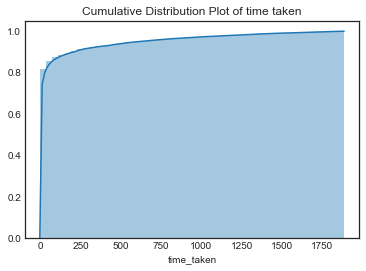

In [37]:
%%time
# The cumulative distribution of the time taken variable: This enables us to see the probability distribution
_ = sns.distplot(sfr['time_taken'],hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
_ = plt.title('Cumulative Distribution Plot of time taken')

In [38]:
weekday_cnt =  dict({'Monday':0,'Tuesday':0,'Wednesday':0,'Thursday':0,'Friday':0})
weekday_cnt_max =  dict({'Monday':0,'Tuesday':0,'Wednesday':0,'Thursday':0,'Friday':0})
for k,d in sfr.groupby(['year','month']) : 
    weekday_cnt_max[d.groupby('file_day')['time_taken'].count().idxmax()] = weekday_cnt_max[d.groupby('file_day')['time_taken'].count().idxmax()] + 1
    weekday_cnt[d.groupby('file_day')['time_taken'].count().idxmin()] = weekday_cnt[d.groupby('file_day')['time_taken'].count().idxmin()] + 1
print("Number of months for which each week day is least crowded:\n",weekday_cnt)
print("Number of months for which each week day is most crowded:\n",weekday_cnt_max)

Number of months for which each week day is least crowded:
 {'Monday': 25, 'Tuesday': 0, 'Wednesday': 12, 'Thursday': 5, 'Friday': 6}
Number of months for which each week day is most crowded:
 {'Monday': 6, 'Tuesday': 12, 'Wednesday': 8, 'Thursday': 11, 'Friday': 11}


Clear winner is Monday, among least crowded weekdays, contrary to the belief of Wednesday. We will validate this observation with statistical tests later.

There is no such clear majority for most crowded. We could still conduct a 2 sample t-test by grouping Monday and Wednesday into one group and Tuesday, Thursday, Friday into another group.

file_day
Friday       0.5747
Monday       0.6132
Thursday     0.5748
Tuesday      0.5884
Wednesday    0.5664
Name: time_taken, dtype: float64

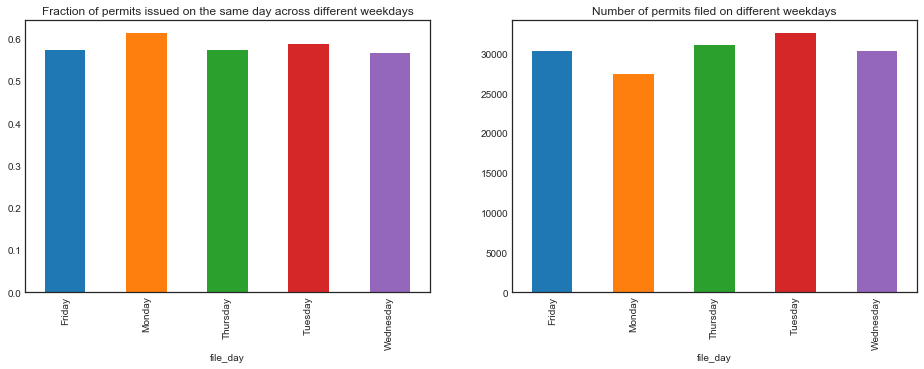

In [39]:
# Examinining if certain weekdays are efficient at processing wrt the permits they receive on that day.
_ = plt.figure(figsize=(16,5))
_ = plt.subplot(1,2,1)
(sfr.loc[sfr['time_taken']==0,:].groupby('file_day')['time_taken'].count()/sfr.groupby('file_day')['time_taken'].count()).plot.bar()
_ = plt.title('Fraction of permits issued on the same day across different weekdays')
_ = plt.subplot(1,2,2)
sfr.groupby('file_day')['time_taken'].count().plot.bar()
_ = plt.title('Number of permits filed on different weekdays')
np.round(sfr.loc[sfr['time_taken']==0,:].groupby('file_day')['time_taken'].count()/sfr.groupby('file_day')['time_taken'].count(),4)

**Observations:**
+ Mondays are most efficient.
+ Next place is Tuesday, although Thursday and Friday closely follow.
+ Wednesday is worst in issuing on the same day.
+ Interestingly, Mondays receive least number of applications, and Wednesday's receive next least number of applications, yet they are not efficient.
+ Tuesdays are most crowded as per the previous analysis and also in the second plot above. However, Tuesday's come second in issuing permits on the same day.

These differences will have to be statistically validated.

In [40]:
def conv_quarter(v) :
    if v < 4 :
        q = 1
    elif v < 7:
        q = 2
    elif v < 10:
        q = 3
    else :
        q = 4
    return q

In [41]:
sfr = sfr.assign(quarter=sfr.month.apply(conv_quarter))

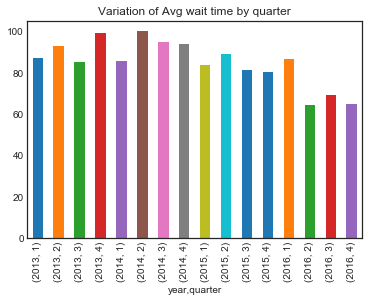

In [42]:
_ = sfr.groupby(['year','quarter']).time_taken.mean().plot.bar()
_ = plt.title('Variation of Avg wait time by quarter')

There is no visible pattern w.r.t quarters over years.

#### Revised Cost Vs Time Taken

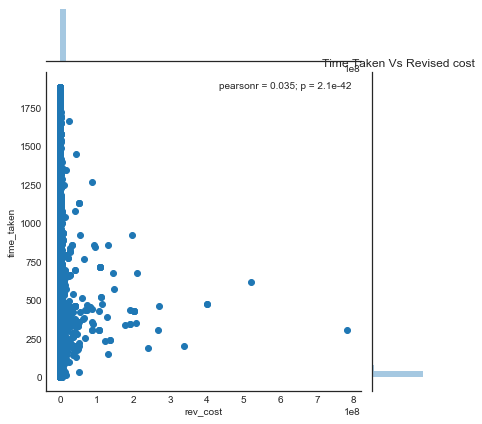

In [43]:
_ = sns.jointplot('rev_cost','time_taken',sfr)
_ = plt.title('Time Taken Vs Revised cost')

There is no apparent correlation between revised cost and time taken. Convert to Logarithm and see. Care is taken to see that log (0) does not happen

Percentage of zeros in Revised Cost: 5.39


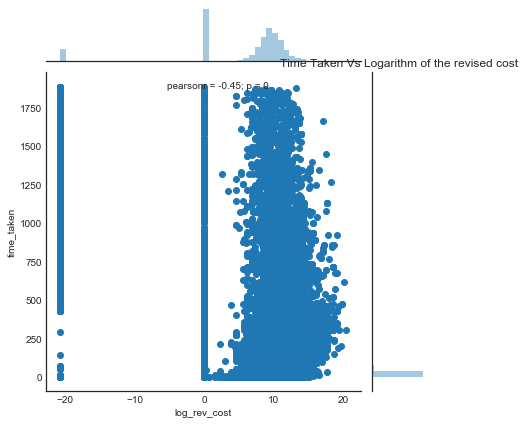

In [44]:
# Convert to Logarithm
#sfr['log_est_cost'] = np.log(sfr['est_cost']+0.00000001)  # Keep it small enough to separate from the actial data
print('Percentage of zeros in Revised Cost:',round(100*(sfr['rev_cost']==0).sum()/(sfr['rev_cost']==0).count(),2))
sfr['log_rev_cost'] = np.log(sfr['rev_cost']+0.000000001)
_ = sns.jointplot('log_rev_cost','time_taken',sfr)
_ = plt.title('Time Taken Vs Logarithm of the revised cost')

This graph reveals a few points:

+ The pearson correlation is negative. Looking at the scatterplot, it does not make practical sense.
+ The bin with close to zero values for revised cost have maximum count in the histogram of log_rev_cost. The bin with negative center value is corresponding to the NaNs in revised cost. To prevent error, they were substituted with very small values. 
+ One observation is, if zeros were substituted with 0.1, the correlation was -0.18, and if they were substituded with 0.000000001, it is -0.45. There are only 5.39% zeros, however 3% of these were NaN's replaced with zeros in data wrangling step. 
+ **The above observation certainly means that absence of entry in cost column delays the issuance time**. 

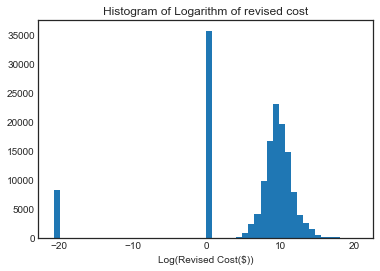

In [45]:
# Clearer view of Logarithm of revised cost
_ = plt.hist(sfr['log_rev_cost'],bins=50)
_ = plt.xlabel('Log(Revised Cost($))')
_ = plt.title('Histogram of Logarithm of revised cost')

The Logarithm of Revised cost is nearly normal. 

#### Time Taken w.r.t Permit Type

In [46]:
sfr.groupby('perm_typ_def')['time_taken'].describe().sort_values('mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
perm_typ_def,,,,,,,,
new construction,284.0,627.014085,367.120925,60.0,364.75,495.5,854.25,1748.0
new construction wood frame,843.0,559.849348,411.034715,2.0,231.50,446.0,808.00,1840.0
demolitions,477.0,542.851153,436.945616,0.0,166.00,450.0,820.00,1827.0
additions alterations or repairs,11350.0,425.374449,405.383110,0.0,137.00,274.0,579.00,1883.0
wall or painted sign,374.0,350.553476,523.717974,0.0,3.00,43.0,687.50,1862.0
sign - erect,2289.0,221.117955,432.727898,0.0,2.00,19.0,158.00,1881.0
grade or quarry or fill or excavate,76.0,210.144737,415.282866,0.0,44.00,70.0,148.75,1806.0
otc alterations permit,136103.0,47.405289,210.790434,0.0,0.00,0.0,5.00,1883.0


**Observations:**
1) As expected, New construction permits take longer time to get issued. But their representation in the data set is very low. New construction minimum itself is 60 days, this might be as per rules for a new construction.     
2) Only one category of the permits, that is otc alteration permit has at least 50% of the applications issued on the same day.   
3) OTC alterations permit category is huge with 89.66% of the records. Next big category is again additions alterations or repairs. But this second category does not get issued as fast. OTC alterations permit, as the name suggests, is "Over the Counter" permit. Ideally all of them have to be issued immediately.    

#### Plot of the Median Cost and Time Taken of a Building By Permit Type

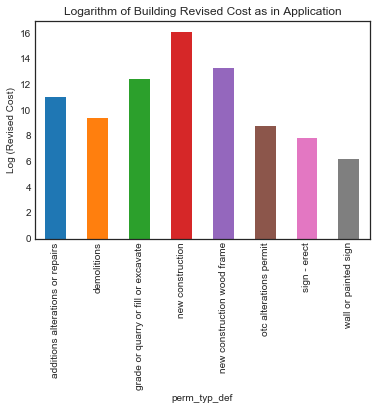

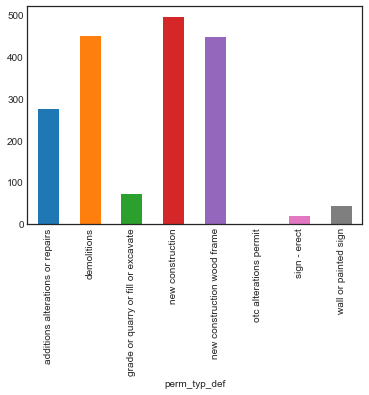

In [47]:
_ = sfr.groupby('perm_typ_def')['log_rev_cost'].median().plot.bar()
_ = plt.title('Logarithm of Building Revised Cost as in Application')
_ = plt.ylabel('Log (Revised Cost)')
_ = plt.figure()
_ = sfr.groupby('perm_typ_def')['time_taken'].median().plot.bar()

The new construction is high cost, but it takes highest average time. Its representation is low in the dataset, so it may not have much impact on the overal correlation properties between revised cost and time taken columns.
For others it is hard to conclude anything from these visualizations. **This kind of justifies the use of statistical models to understand the relations and make predictions for future applications.**

The Special cases Revised Cost = 0 and Revised Cost being too small, something like < 20$ need special analysis, to see the characteristics of average time taken.

In [48]:
(sfr.loc[sfr['rev_cost'] == 0,:]).groupby('perm_typ_def')['time_taken'].describe().sort_values('mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
perm_typ_def,,,,,,,,
grade or quarry or fill or excavate,2.0,1787.500000,26.162951,1769.0,1778.25,1787.5,1796.75,1806.0
sign - erect,315.0,1148.698413,425.829794,433.0,754.50,1253.0,1517.00,1881.0
wall or painted sign,88.0,1121.840909,391.294253,435.0,771.00,1100.5,1417.25,1862.0
additions alterations or repairs,2123.0,965.313707,413.484057,425.0,622.00,859.0,1290.00,1883.0
demolitions,108.0,947.944444,412.298795,427.0,574.75,957.0,1237.25,1827.0
new construction wood frame,215.0,917.102326,363.646779,426.0,584.50,855.0,1221.00,1840.0
new construction,84.0,873.976190,395.104866,425.0,526.00,803.0,1157.00,1748.0
otc alterations permit,5251.0,652.187012,619.824207,0.0,0.00,621.0,1177.00,1883.0


**Remarks:** If revised cost is 0, then except otc alterations permit,  all of them take a minimum of 1 year 2 months to be issued. Even the OTC alterations permits have less chances of getting issued on the same day.


In [49]:
sfr_sub = (sfr.loc[sfr['rev_cost'] < 20,:])
np.round(sfr_sub.loc[sfr_sub['rev_cost'] > 0,:].groupby('perm_typ_def')['time_taken'].describe(),2).sort_values('mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
perm_typ_def,,,,,,,,
additions alterations or repairs,458.0,260.63,344.45,0.0,63.0,135.5,292.5,1834.0
wall or painted sign,8.0,240.12,390.84,0.0,44.0,52.5,280.0,1168.0
sign - erect,9.0,206.44,184.53,0.0,16.0,362.0,362.0,362.0
grade or quarry or fill or excavate,6.0,41.67,20.41,0.0,50.0,50.0,50.0,50.0
otc alterations permit,35234.0,11.92,105.48,0.0,0.0,0.0,0.0,1882.0
demolitions,1.0,0.00,NaN,0.0,0.0,0.0,0.0,0.0


**Comments:** Notice that new construction permit types are absent in this table. Minimum time taken is 0, hence small entries are not the problem, absence of entry for the cost is the problem. 

**Recommendation:** Always put a valid entry for cost in applications.

#### Existing/Proposed Use variables

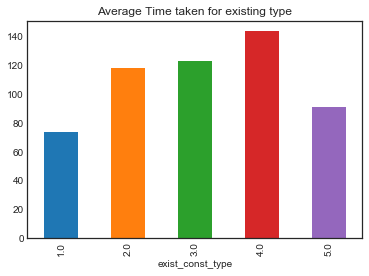

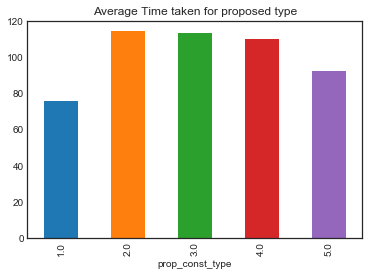

In [50]:
_ = sfr.groupby('exist_const_type').time_taken.mean().plot.bar()
_ = plt.title('Average Time taken for existing type')
_ = plt.figure()
_ = sfr.groupby('prop_const_type').time_taken.mean().plot.bar()
_ = plt.title('Average Time taken for proposed type')

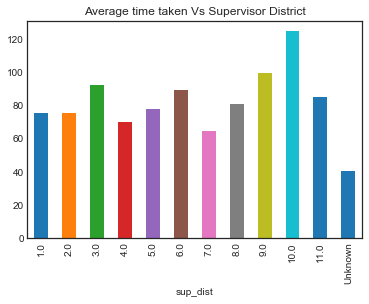

In [51]:
_ = sfr.groupby('sup_dist').time_taken.mean().plot.bar()
_ = plt.title('Average time taken Vs Supervisor District')

There is a clear variability across different supervisor districts

#### Some more numerical EDAs

In [52]:
np.round(sfr.groupby('fire_only_permit')['time_taken'].describe(),2)

,count,mean,std,min,25%,50%,75%,max
fire_only_permit,,,,,,,,
N,137503.0,89.36,271.72,0.0,0.0,0.0,15.0,1883.0
Y,14293.0,38.78,185.67,0.0,0.0,0.0,3.0,1883.0


In [53]:
np.round(sfr.groupby('site_permit')['time_taken'].describe(),2)

,count,mean,std,min,25%,50%,75%,max
site_permit,,,,,,,,
N,147447.0,70.88,248.17,0.0,0.0,0.0,9.0,1883.0
Y,4349.0,549.85,380.17,0.0,258.0,437.0,720.0,1883.0


In [54]:
np.round(sfr.groupby('strct_notif')['time_taken'].describe(),2)

,count,mean,std,min,25%,50%,75%,max
strct_notif,,,,,,,,
N,146249.0,74.18,253.60,0.0,0.0,0.0,9.0,1883.0
Y,5547.0,359.31,388.73,0.0,35.0,247.0,525.0,1878.0


The above 3 tables are self-explanatory.
#### Plansets Variable

In [55]:
np.round(sfr.groupby('plansets')['time_taken'].describe(),2)

,count,mean,std,min,25%,50%,75%,max
plansets,,,,,,,,
0.0,49124.0,15.66,131.41,0.0,0.0,0.0,0.0,1882.0
2.0,74899.0,155.75,340.60,0.0,1.0,11.0,94.0,1883.0
3.0,246.0,231.12,70.71,72.0,225.0,225.0,225.0,1181.0
4.0,2.0,240.00,175.36,116.0,178.0,240.0,302.0,364.0
6.0,2.0,327.00,0.00,327.0,327.0,327.0,327.0,327.0
20.0,1.0,1244.00,NaN,1244.0,1244.0,1244.0,1244.0,1244.0
9000.0,1.0,2.00,NaN,2.0,2.0,2.0,2.0,2.0


The 4 plansets out of 7 have very insignificant representation. The other 3 are interesting. The planset '0' is the fastest issued one and '3' is the slowest among these 3.

## **Conclusions from Exploratory Data Analysis:**     

1) What is the best day of the week to visit DBI, to file an application form? Is the popular belief “mid-week (Wednesday) is the least crowded and hence best to visit government or city agencies” true in this case?     

-Over the 4 years, it is found that in 25 out of 48 months, Monday has been the week day with least number of permit applications. Wednesday was least crowded only in 8 months. It is also interesting to know that while Tuesday was the week to receive maximum number of applications in 12 months, it is not a clear winner. So, there is not a clear "Most" crowded week day.

2) What type of permits are mostly issued on the same day of filing?

"OTC alterations permits" as the name suggests, are issued mostly on the same day of filing. More than 75% of these are issued within a week. 

3) Which types take least average time issue if not issued on the same day?   

Once again the answer is OTC alterations permits. They are 89% of the total permit applications, and they have very low average wait time.

4) Is there any particular quarter of each year which has higher application counts or average wait times? Can it be justified from the business knowledge?         

No.

5) Is there a correlation between the supervisor district and wait times?       
Certainly there is difference in wait times based on what is entered as supervisor district in the application form. It is shown above with a bar chart.

6) How does the permit times vary across plansets?   
There are 7 different plansets, of which 3 seem significant. They are highly variable

7) How is permit times related to cost?   
We looked at permit times' relationship with revised cost, as that is the most recent estimate. There is no clear relationship when the cost is some reasonable number. However, if the cost is not entered or entered too low to believe, there is a greater possibility of delay in issuing.


## Final Remark: 
The EDA gave good insights into nature of the data. It seems like, prediction of time taken to issue a permit in number of days is difficult. A better way could be to convert it to categories like 'taking less than 15 days', 'less than 3 months', 'less than a year' and 'more than a year'.